In [2]:

import diamon_read_data as dia
import influx_data_query as idb
import numpy as np
import pandas as pd
import datetime
import pickle
import plotting as p
import importlib
import pytz
import diamon_analysis as da
import main
from influx_data_utils.process_influx_data.datetime_localiser import \
    DatetimeLocaliser
ts2_path = r"C:\Users\sfs81547\Documents\diamon\ts2\DIAMON*"
location_path = r"C:\Users\sfs81547\OneDrive - Science and Technology Facilities Council\Documents\ISIS\Diamon Project\Code\data\Measurement_location.csv"
fname = "shutters_pickle.pkl"


In [3]:
#dont run again
"""
dates = [datetime.datetime(2022,10,10), datetime.datetime(2023,2,11)]
query_data = da.influx_db_query(dates)
da.save_pickle(query_data, "11-02-shutters")
"""

'\ndates = [datetime.datetime(2022,10,10), datetime.datetime(2023,2,11)]\nquery_data = da.influx_db_query(dates)\nda.save_pickle(query_data, "11-02-shutters")\n'

In [4]:
importlib.reload(main)
importlib.reload(dia)
importlib.reload(da)
main_data = main.main()

In [96]:
data = main_data["all_data"]
data = {key: da.filter_low_beam_current(result, 25) for key, result in data.items()}
beam_df = main_data["df"]
open_shutters = main_data["open_shutter"]
closed_shutters = main_data["closed_shutter"]

In [97]:
importlib.reload(da)
open_shutters = da.filter_shutter_status(data, True)
closed_shutters = da.filter_shutter_status(data, False)

In [98]:
importlib.reload(da)
#run once
open_shutters = da.average_repeated_data(open_shutters)
closed_shutters = da.average_repeated_data(closed_shutters)


In [ ]:
importlib.reload(p)
for key, result in data.items():
    if result["reference"]["Measurement Reference"].iloc[0][1] == "W":
        p.plot_dose_time(result)

In [ ]:
for key, measurement in data.items():
    if measurement["reference"]["Measurement Reference"].iloc[0][1:3] == "Le":
        beamline = da.get_names(measurement["reference"])[1]
        p.plot_energy_time(measurement, key, beamline)

In [ ]:
for key, beamline in beam_df.items():
    if key == "Le":
        p.plot_dose_distance(beamline, key)
        p.plot_combined_spect(beamline, key)
        p.plot_dose_rate(beamline, key)
        p.direction_bar_plot(beamline, key)
        p.stack_bar_plot(beamline, key=key)

In [ ]:
importlib.reload(p)
p.plot_dose_map(open_shutters)
p.plot_dose_map(closed_shutters)


In [ ]:
p.plot_energy_map(open_shutters)
p.plot_energy_map(closed_shutters)

In [100]:
open_shutters = open_shutters.dropna(subset = ['x', 'y', 'norm_dose'])
closed_shutters = closed_shutters.dropna(subset = ['x', 'y', 'norm_dose'])

It should be noted above:
-area of high dose for nimrod shutter closed position not plotted for shutter open so no direct comparison

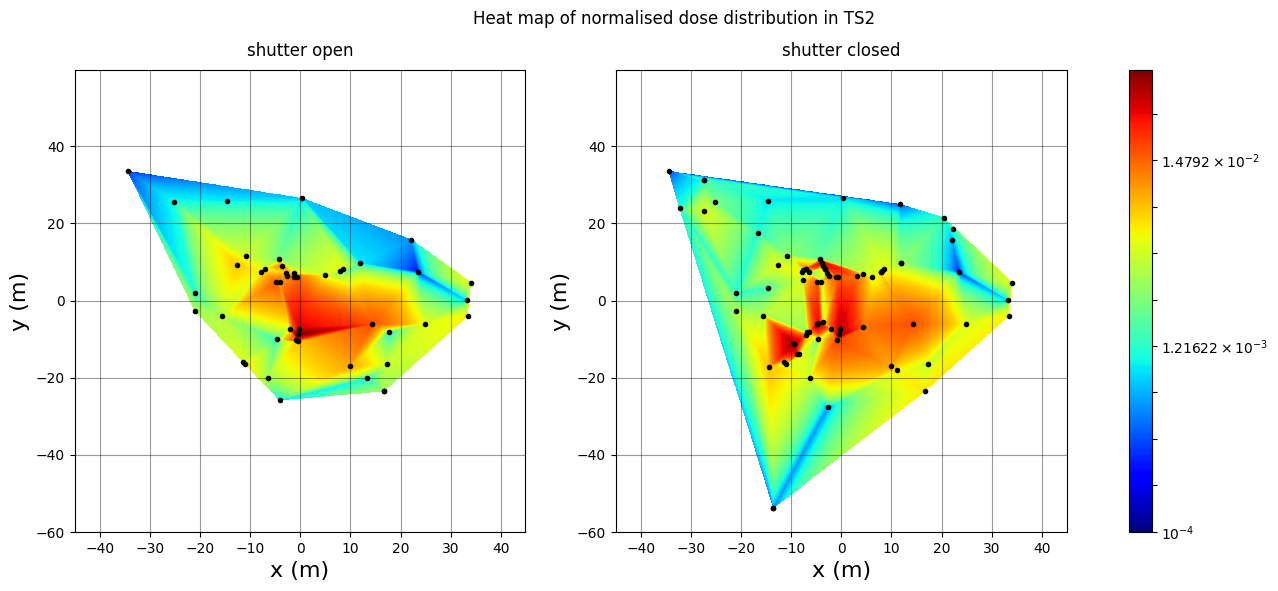

In [119]:
# make a df for columns: x, y, dose, ther, epi, fast. index is status
importlib.reload(p)
open_plot_df = open_shutters[['x', 'y',"norm_dose", 'Ther%', "Epit%", "Fast%"]]
closed_plot_df = closed_shutters[['x', 'y',"norm_dose", 'Ther%', "Epit%", "Fast%"]]
shutter_dict = {"open": open_plot_df, "closed": closed_plot_df}
vmin = 1e-4
vmax = 0.05
levels = np.logspace(np.log10(vmin),np.log10(vmax), 200)
x = [shutter_dict["open"]['x'], shutter_dict["closed"]['x']]
y = [shutter_dict["open"]['y'], shutter_dict["closed"]['y']]
z = [shutter_dict["open"]['norm_dose'], shutter_dict["closed"]['norm_dose']]
p.plot_dose_map(x,y,z, "normalised dose", levels)

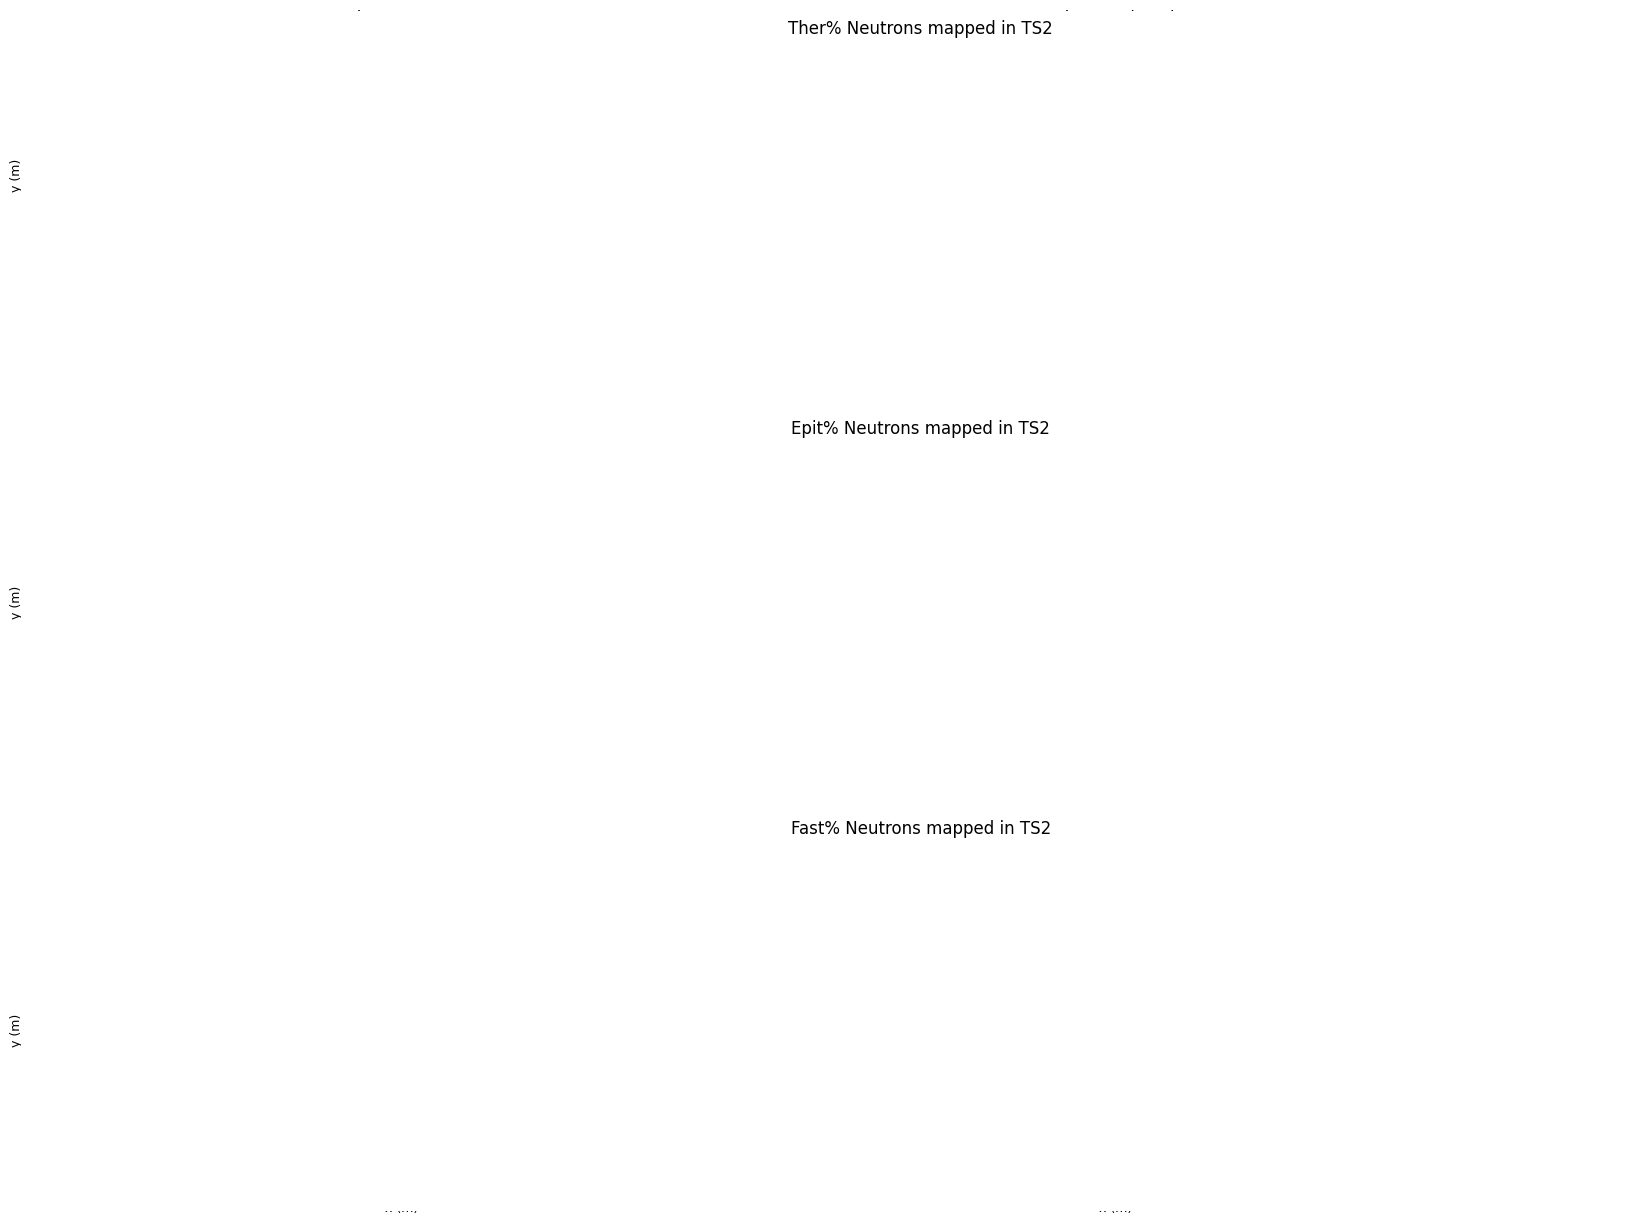

In [127]:
importlib.reload(p)
import matplotlib.pyplot as plt
plot_list = ['Ther%', "Epit%", "Fast%"]
fig = plt.figure(figsize=(18,12))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
subfigs = fig.subfigures(nrows=3, ncols=1)
levels = np.linspace(0, 100, 21)
for i, (plot, subfig) in enumerate(zip(plot_list, subfigs)):
    subfig.suptitle(plot + " Neutrons mapped in TS2")
    axs = subfig.subplots(nrows=1, ncols=2)
    vmin = 0
    vmax = 110
    x_array = [shutter_dict["open"]['x'], shutter_dict["closed"]['x']]
    y_array = [shutter_dict["open"]['y'], shutter_dict["closed"]['y']]
    z_array = [shutter_dict["open"][plot], shutter_dict["closed"][plot]]
    
    for j, (x, y, z, ax) in enumerate(zip(x_array, y_array, z_array, axs[i].ravel())):
        if j  == 0:
            label = "open"
        elif j == 1:
            label = "closed"
        scat = p.contour_plot(x,y,z, ax,plot,  label, levels, norm=None)
fig.colorbar(scat, ax=axs.ravel().tolist())
plt.show()
